In [5]:
import nibabel as nb 
import numpy as np
import pandas as pd  
from scipy.stats import linregress, f_oneway
import seaborn as sns
import matplotlib.pyplot as plt
from Functional_Fusion.dataset import decompose_pattern_into_group_indiv_noise
from scripts import decomposing_variances
from scripts import make_atlas
#from scripts import bold_normalization 
import Functional_Fusion.dataset as ds
import Functional_Fusion.atlas_map as am
from scipy.stats import ttest_1samp
from scipy.stats import t

In [3]:
wk_dir = '/Volumes/diedrichsen_data$/data/Cerebellum/Pontine7T/RegionOfInterest_BOLDMNI/data/group' #2min52 sec to load

dentate = np.load(wk_dir + '/data_dentate.npy')  #shape (16,16,10,voxels)
cereb_gray = np.load(wk_dir + '/data_cerebgray.npy')
redn = np.load(wk_dir + '/data_rednucleus.npy')   
thalamus = np.load(wk_dir + '/data_thalamus.npy')       
pontine = np.load(wk_dir + '/data_pontine.npy') 
olive = np.load(wk_dir + '/data_olive.npy') 


In [155]:
#group-level regression (creating .tsv files)

pt_base ='/Volumes/diedrichsen_data$/data/Cerebellum/Pontine7T'

x = np.mean(olive, axis=(0,1,3)) #shape (10,) #avg activity per condition across subjects, runs, and voxels 
y = np.mean(dentate, axis=(0,1,3))  

condition_labels = ["Instr", "Vis_S", "F_Seq", "ToM", "N_back", "Sem_Pred", "Act_Obs", "Flex_Ext", "Rest", "Rom_mov"]

results = []

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)
regression_line = f"{slope:.4f} * x + {intercept:.4f}"  # Store as a string
F_value = (r_value**2 / (1 - r_value**2)) * ((len(condition_labels) - 2) / 1)

for i in range(len(condition_labels)):
    results.append(["group", "dentate vs olive", condition_labels[i], x[i], y[i], regression_line, r_value**2, F_value, p_value])

# Convert to a DataFrame
df = pd.DataFrame(results, columns=["Subjects", "ROIs", "cond", "x", "y", "regression line", "R2", "F-value", "p-value"])

# Save to TSV
df.to_csv("group_ROI_correlations.tsv", sep="\t", mode = 'a', index=False)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


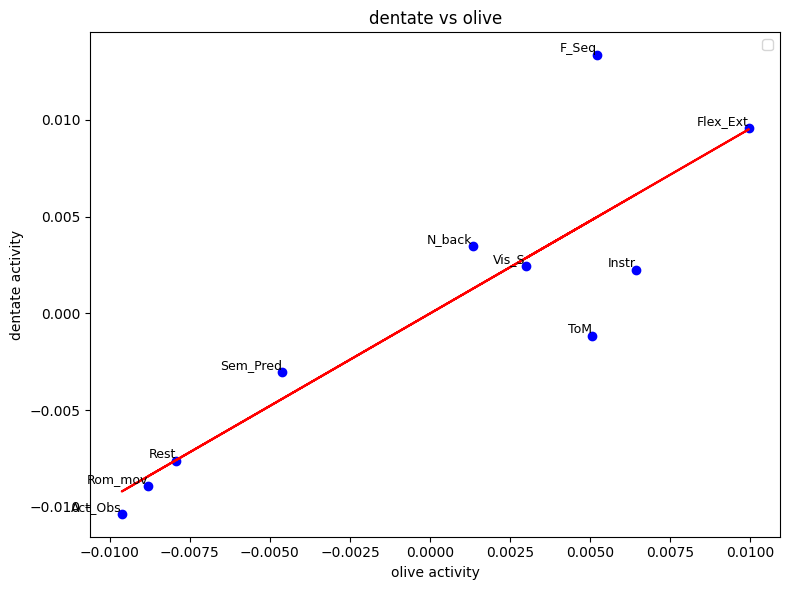

In [33]:
#group level plots

#dentate vs cereb_gray
#cereb_gray vs pontine
#cereb_gray vs olive
#dentate vs pontine
#thalamus vs dentate
#redn vs dentate
#olive vs redn
#dentate vs olive

df = pd.read_csv('group_ROI_correlations.tsv', sep="\t")

roi = 'dentate vs olive'  # Specify the subject
roi_data = df[df['ROIs'] == roi]

# Extract the data for plotting
x = roi_data['x']
y = roi_data['y']

condition_labels = roi_data['cond']
regression_line = roi_data['regression line'].iloc[0]  
 # Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color="blue")

# Extract slope and intercept for the regression line
slope, intercept = map(float, regression_line.split(" * x + "))  # This assumes your regression line is in the form "slope * x + intercept"
plt.plot(x, slope * x + intercept, color="red")

    # Add labels and title
plt.xlabel(f"{roi.split(' vs ')[1]} activity")
plt.ylabel(f"{roi.split(' vs ')[0]} activity")
plt.title(f"{roi}")
plt.legend()

r_squared = float(roi_data['R2'].iloc[0])  # Extract the R² value from the dataframe for this ROI
p_value = float(roi_data['p-value'].iloc[0])  # Extract the p-value from the dataframe for this ROI

    # Display R² and p-value on the plot
#plt.text(0.05, 0.95, f"R² = {r_squared:.4f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', color='black')
#plt.text(0.05, 0.90, f"p = {p_value:.4f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', color='black')

    # Optionally, add labels for conditions
for i, label in enumerate(condition_labels):  # Use enumerate to iterate over condition labels
    plt.text(x.iloc[i], y.iloc[i], label, fontsize=9, color='black', ha='right', va='bottom')

    # Show the plot
plt.tight_layout()
plt.show()


In [166]:
#group: list R^2 values and p-value per roi

df = pd.read_csv('group_ROI_correlations.tsv', sep="\t")

# Iterate over each subject and selected ROI combination
for roi in df['ROIs'].unique():  # Iterate over each unique roi

    roi_data = df[df['ROIs'] == roi]  # Filter data for the current ROI
   
    r_squared = roi_data['R2'].iloc[0]  
    p_value = roi_data['p-value'].iloc[0]
        
        # Print the R² value for the subject-ROI pair
    print(f"group {roi}: R² = {r_squared:.4f}, p = {p_value:.4f}")


group dentate vs cereb_gray: R² = 0.8231, p = 0.0003
group cereb_gray vs pontine: R² = 0.1861, p = 0.2132
group cereb_gray vs olive: R² = 0.6128, p = 0.0074
group thalamus vs dentate: R² = 0.6331, p = 0.0059
group dentate vs pontine: R² = 0.2153, p = 0.1767
group redn vs dentate: R² = 0.7952, p = 0.0005
group olive vs redn: R² = 0.7291, p = 0.0017
group dentate vs olive: R² = 0.7632, p = 0.0010


In [127]:
#subject-wise regression (creating .tsv files)

pt_base ='/Volumes/diedrichsen_data$/data/Cerebellum/Pontine7T'

T = pd.read_csv(f'{pt_base}/participants.tsv', sep='\t')
subj = [i for i, good_value in zip(T.participant_id, T.good) if good_value == 1]

subj_avg_dentate = np.mean(redn, axis=(1,3))  # shape (16,10) (subjects x conditions)
subj_avg_olive = np.mean(dentate, axis=(1,3))  # shape  (16,10)

condition_labels = ["Instr", "Vis_S", "F_Seq", "ToM", "N_back", "Sem_Pred", "Act_Obs", "Flex_Ext", "Rest", "Rom_mov"]

results = []

# Loop over subjects
for subj_idx, subj_id in enumerate(subj):
    x = subj_avg_olive[subj_idx, :]
    y = subj_avg_dentate[subj_idx, :]

    # Linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    regression_line = f"{slope:.4f} * x + {intercept:.4f}"  # Store as a string
    F_value = (r_value**2 / (1 - r_value**2)) * ((len(condition_labels) - 2) / 1)

    for i in range(len(condition_labels)):
        results.append([subj_id, "dentate vs olive", condition_labels[i], x[i], y[i], regression_line, r_value**2, F_value, p_value])

# Convert to a DataFrame
df = pd.DataFrame(results, columns=["Subjects", "ROIs", "cond", "x", "y", "regression line", "R2", "F-value", "p-value"])

# Save to TSV
df.to_csv("subjectwise_ROI_correlations.tsv", sep="\t", mode = 'a', index=False)


In [20]:
#subject-wise regression (creating .tsv files)

#dentate vs cereb_gray
#cereb_gray vs pontine
#cereb_gray vs olive
#dentate vs pontine
#thalamus vs dentate
#redn vs dentate
#olive vs redn
#dentate vs olive

pt_base ='/Volumes/diedrichsen_data$/data/Cerebellum/Pontine7T'

T = pd.read_csv(f'{pt_base}/participants.tsv', sep='\t')
subj = [i for i, good_value in zip(T.participant_id, T.good) if good_value == 1]

subj_avg_olive = np.mean(olive, axis=(1,3))  # shape (16,10) (subjects x conditions)
subj_avg_dentate = np.mean(dentate, axis=(1,3))  # shape  (16,10)

condition_labels = ["Instr", "Vis_S", "F_Seq", "ToM", "N_back", "Sem_Pred", "Act_Obs", "Flex_Ext", "Rest", "Rom_mov"]

results = []

for subj_idx, subj_id in enumerate(subj):
    x = subj_avg_olive[subj_idx, :]
    y = subj_avg_dentate[subj_idx, :]

    # Linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    regression_line = f"{slope:.4f} * x + {intercept:.4f}"
    F_value = (r_value**2 / (1 - r_value**2)) * ((len(condition_labels) - 2) / 1)
    
    # t-value for slope significance
    t_value = slope / std_err  
    slope_p_value = 2 * t.sf(abs(t_value), df=len(condition_labels) - 2)  # Two-tailed test

    for i in range(len(condition_labels)):
        results.append([
            subj_id, 
            "dentate vs olive", 
            condition_labels[i], 
            x[i], 
            y[i], 
            regression_line, 
            r_value**2, 
            F_value, 
            p_value,
            std_err,          # Standard Error of the slope
            t_value,          # t-value for slope significance
            slope_p_value     # p-value for slope significance
        ])

# Convert to DataFrame
df = pd.DataFrame(results, columns=[
    "Subjects", "ROIs", "cond", "x", "y", 
    "regression line", "R2", "F-value", "p-value",
    "SE_slope", "t-value", "slope_p-value"
])

# Save to TSV
df.to_csv("subjectwise_ROI_correlations.tsv", sep="\t", mode='a', index=False)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


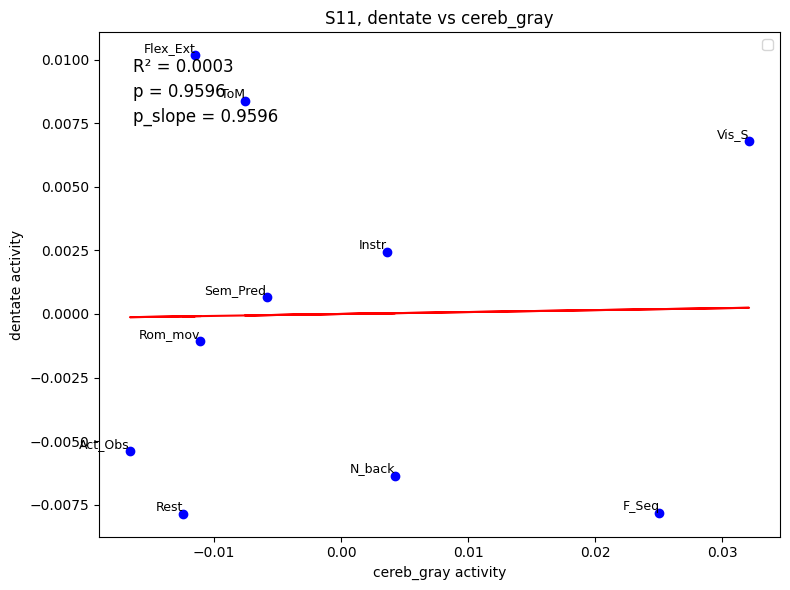

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


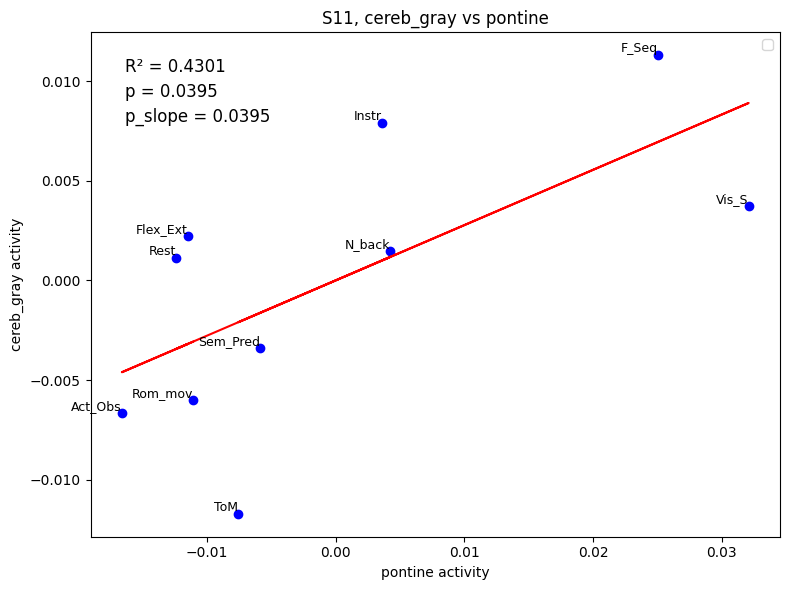

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


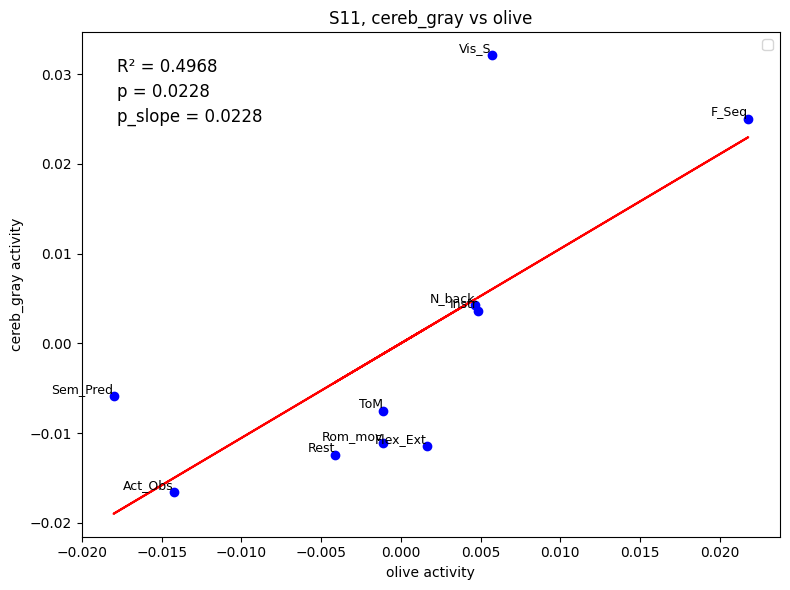

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


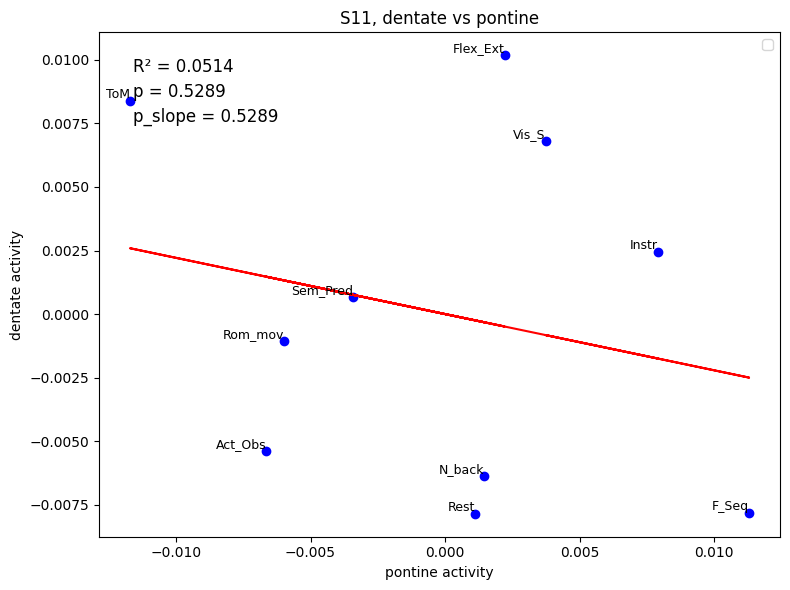

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


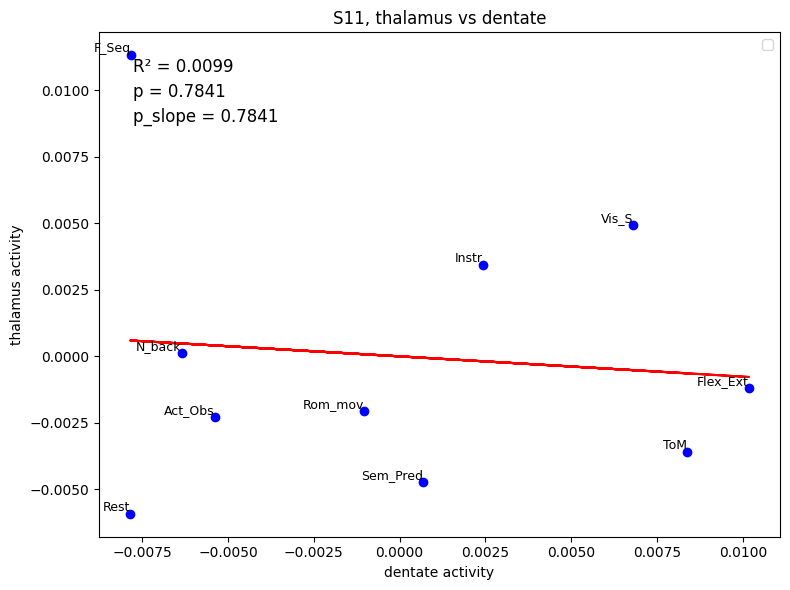

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


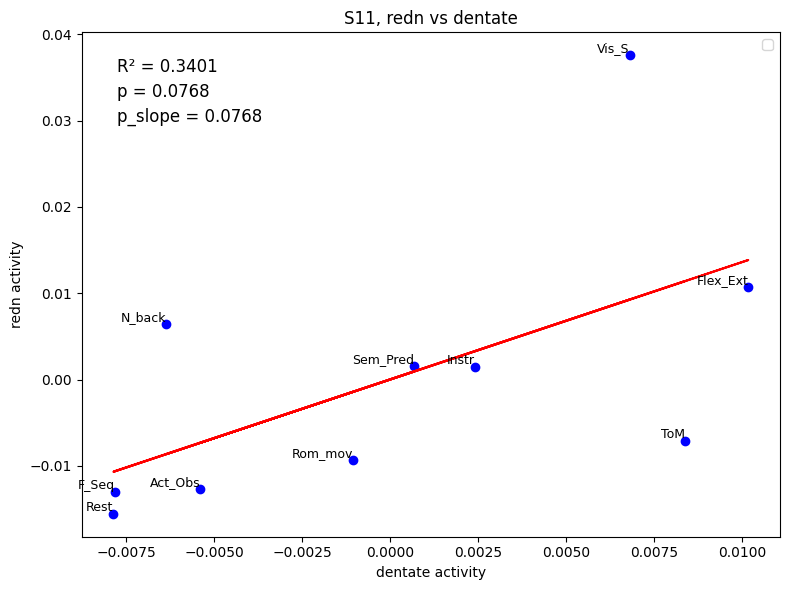

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


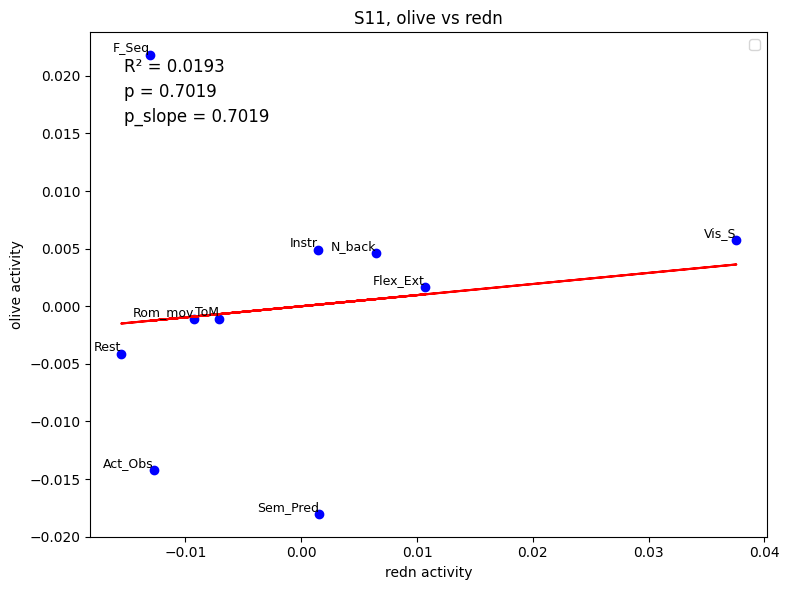

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


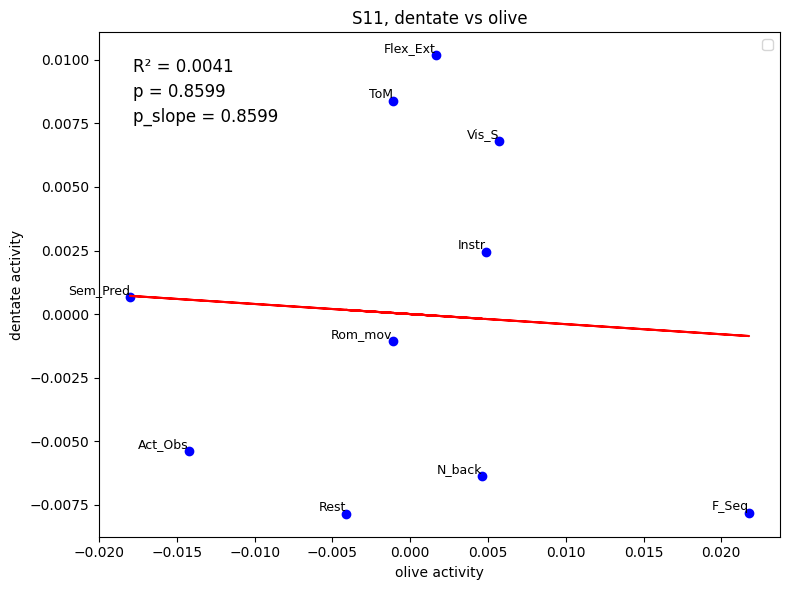

In [23]:

# Read the data from the .tsv file
df = pd.read_csv('subjectwise_ROI_correlations.tsv', sep="\t")

subject_id = 'S11'  # Specify the subject
subject_data = df[df['Subjects'] == subject_id]

# Loop through each ROI (or filter if needed)
for roi in subject_data['ROIs'].unique():  # Loop through the unique ROIs
    roi_data = subject_data[subject_data['ROIs'] == roi]

    # Extract the data for plotting
    x = roi_data['x']
    y = roi_data['y']
    condition_labels = roi_data['cond']
    regression_line = roi_data['regression line'].iloc[0]  # Assuming the same regression line for each ROI

    # Create a scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, color="blue")

    # Extract slope and intercept for the regression line
    slope, intercept = map(float, regression_line.split(" * x + "))  # This assumes your regression line is in the form "slope * x + intercept"
    plt.plot(x, slope * x + intercept, color="red")

    # Add labels and title
    plt.xlabel(f"{roi.split(' vs ')[1]} activity")
    plt.ylabel(f"{roi.split(' vs ')[0]} activity")
    plt.title(f"{subject_id}, {roi}")
    plt.legend()

    r_squared = float(roi_data['R2'].iloc[0])  # Extract the R² value from the dataframe for this ROI
    p_value = float(roi_data['p-value'].iloc[0])  # Extract the p-value from the dataframe for this ROI
    p_value_slope = float(roi_data['slope_p-value'].iloc[0])

    # Display R² and p-value on the plot
    plt.text(0.05, 0.95, f"R² = {r_squared:.4f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', color='black')
    plt.text(0.05, 0.90, f"p = {p_value:.4f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', color='black')
    plt.text(0.05, 0.85, f"p_slope = {p_value:.4f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', color='black')


    # Optionally, add labels for conditions
    for i, label in enumerate(condition_labels):  # Use enumerate to iterate over condition labels
        plt.text(x.iloc[i], y.iloc[i], label, fontsize=9, color='black', ha='right', va='bottom')

    # Show the plot
    plt.tight_layout()
    plt.show()


In [25]:
#List R^2 values and p-value per subject

# Load the .tsv file
df = pd.read_csv('subjectwise_ROI_correlations.tsv', sep="\t")

# Define the ROIs you want to include
selected_rois = ["dentate vs cereb_gray"]  # Replace with actual ROI names

# Filter the DataFrame to only include selected ROIs
df_filtered = df[df['ROIs'].isin(selected_rois)]

# Iterate over each subject and selected ROI combination
for subj_id in df_filtered['Subjects'].unique():  # Iterate over each unique subject
    subject_data = df_filtered[df_filtered['Subjects'] == subj_id]
    
    for roi in subject_data['ROIs'].unique():  # Iterate over each unique selected ROI
        roi_data = subject_data[subject_data['ROIs'] == roi]
        
        # Extract the R² value (assuming it's stored in the "R2" column)
        r_squared = roi_data['R2'].iloc[0]  # Assuming the R² value is the same for all conditions within a subject-ROI pair
        p_value = roi_data['p-value'].iloc[0]
        p_value_slope = roi_data['slope_p-value'].iloc[0]   
        
        # Print the R² value for the subject-ROI pair
        print(f"Subject {subj_id}, ROI {roi}: R² = {r_squared:.4f}, p = {p_value:.4f}, p_slope = {p_value_slope:.4f}")


Subject S98, ROI dentate vs cereb_gray: R² = 0.8807, p = 0.0001, p_slope = 0.0001
Subject S97, ROI dentate vs cereb_gray: R² = 0.7890, p = 0.0006, p_slope = 0.0006
Subject S96, ROI dentate vs cereb_gray: R² = 0.7409, p = 0.0014, p_slope = 0.0014
Subject S95, ROI dentate vs cereb_gray: R² = 0.3772, p = 0.0589, p_slope = 0.0589
Subject S01, ROI dentate vs cereb_gray: R² = 0.5847, p = 0.0100, p_slope = 0.0100
Subject S03, ROI dentate vs cereb_gray: R² = 0.7212, p = 0.0019, p_slope = 0.0019
Subject S04, ROI dentate vs cereb_gray: R² = 0.7009, p = 0.0025, p_slope = 0.0025
Subject S07, ROI dentate vs cereb_gray: R² = 0.7040, p = 0.0024, p_slope = 0.0024
Subject S08, ROI dentate vs cereb_gray: R² = 0.2900, p = 0.1083, p_slope = 0.1083
Subject S10, ROI dentate vs cereb_gray: R² = 0.2445, p = 0.1463, p_slope = 0.1463
Subject S11, ROI dentate vs cereb_gray: R² = 0.0003, p = 0.9596, p_slope = 0.9596
Subject S12, ROI dentate vs cereb_gray: R² = 0.0675, p = 0.4685, p_slope = 0.4685
Subject S13, ROI

In [36]:
#compute anova and t-tests

df = pd.read_csv('subjectwise_ROI_correlations.tsv', sep="\t")

selected_rois = ["dentate vs cereb_gray"]  

# Filter the DataFrame for selected ROIs and R² > 0.50
df_filtered = df[(df['ROIs'].isin(selected_rois)) & (df['R2'] > 0.50)]

# Create an empty list to store residuals for each condition
residuals = []

# Loop through the unique conditions
for condition in df_filtered['cond'].unique():
    condition_data = df_filtered[df_filtered['cond'] == condition]
    
    condition_residuals = []
    
    # Loop through each subject to calculate residuals based on their own regression line
    for subj_id in condition_data['Subjects'].unique():
        subject_data = condition_data[condition_data['Subjects'] == subj_id]
        
        x = subject_data['x']
        y = subject_data['y']
        
        # Extract the regression line (slope, intercept)
        regression_line = subject_data['regression line'].iloc[0]  # Assuming same regression line for a subject across conditions
        slope, intercept = map(float, regression_line.split(" * x + "))
        
        # Calculate predicted y-values based on the regression line
        predicted_y = slope * x + intercept
        
        # Calculate residuals (observed y - predicted y)
        residuals_for_subject = y - predicted_y
        
        # Append subject's residuals to the condition's list
        condition_residuals.append(residuals_for_subject)
    
    # After looping through subjects for this condition, add the residuals for this condition
    residuals.append(np.array(condition_residuals).T)  # Transpose to get subjects as rows

residuals = np.array(residuals).T  # shape is (subjects x 1 x conditions) (10,1,10)

residuals = residuals.squeeze()

residuals = residuals.T  # shape is (conditions x subjects) (10,10)

# Perform one-way ANOVA across conditions (i.e., residuals across all subjects for each condition)
F_value, p_value = f_oneway(*residuals)

print(f"{selected_rois}")
print(f"ANOVA F-value: {F_value:.4f}")
print(f"ANOVA p-value: {p_value:.4f}")

mean_residuals = np.mean(residuals, axis=1)  # Calculate the mean residuals across subjects for each condition

t_values = []
p_values = []

for i, mean_residual in enumerate(mean_residuals):
    t_stat, p_val = ttest_1samp(residuals[i, :], 0)  # Test if mean residual is different from 0
    t_values.append(t_stat)
    p_values.append(p_val)

    flagged_results = []

for i, cond in enumerate(df_filtered['cond'].unique()):
    t_stat, p_val = t_values[i], p_values[i]
    
    # Flag conditions where p-value < 0.10
    flag = "Significant" if p_val < 0.10 else "Not Significant"
    
    flagged_results.append([cond, t_stat, p_val, flag])

# Convert flagged results to DataFrame for better readability
flagged_df = pd.DataFrame(flagged_results, columns=["Condition", "T-statistic", "P-value", "Significance"])

# Display the flagged results
print(flagged_df)


    


['dentate vs olive']
ANOVA F-value: 0.2886
ANOVA p-value: 0.9726
  Condition  T-statistic   P-value     Significance
0     Instr     0.453542  0.680956  Not Significant
1     Vis_S     0.568548  0.609439  Not Significant
2     F_Seq     0.971355  0.403017  Not Significant
3       ToM    -0.038898  0.971416  Not Significant
4    N_back     0.835019  0.464982  Not Significant
5  Sem_Pred    -0.383221  0.727099  Not Significant
6   Act_Obs    -0.049718  0.963472  Not Significant
7  Flex_Ext    -0.717637  0.524815  Not Significant
8      Rest    -0.262114  0.810201  Not Significant
9   Rom_mov    -0.638285  0.568674  Not Significant
